In [24]:
import numpy as np

# Set up matplotlib and use a nicer set of plot parameters
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

import sep

from astropy.io import fits
from astropy.wcs import WCS

%matplotlib inline

# Read in the data

* We are using the `redadd_26_HSC-I_full` object as example

In [23]:
obj_str = 'redadd_26_HSC-I_full'

# Read the header
img_head = fits.open(obj_str + '_img.fits')[0].header

# Read the World Coordinate System information from the header 
img_wcs = WCS(obj_str + '_img.fits')

# Read the image 
img_data = fits.open(obj_str + '_img.fits')[0].data

# Read the sigma (uncertainty) data
sig_data = fits.open(obj_str + '_sig.fits')[0].data

# Read the bad pixel mask data 
msk_data = fits.open(obj_str + '_bad.fits')[0].data

# Show the header 
print(img_head)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1201                                                  NAXIS2  =                 1201                                                  WCSAXES =                    2 / Number of coordinate axes                      CRPIX1  =         601.27088468 / Pixel coordinate of reference point            CRPIX2  =          601.3982165 / Pixel coordinate of reference point            CDELT1  =   -4.66666666667E-05 / [deg] Coordinate increment at reference point  CDELT2  =    4.66666666667E-05 / [deg] Coordinate increment at reference point  CUNIT1  = 'deg'                / Units of coordinate increment and value        CUNIT2  = 'deg'                / Units of coordinate increment and value        CTYPE1  = 'RA---TAN'           / Right a

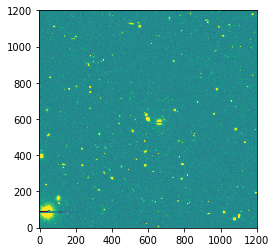

In [8]:
plt.imshow(np.arcsinh(img_data), origin='lower', interpolation='none', 
           vmin=np.nanmean(img_data) - np.nanstd(img_data),
           vmax=np.nanmean(img_data) + np.nanstd(img_data))

# Background subtraction 

* Note that the HSC coadd image is background subtracted.  The reason we need to perform another round of background 
subtraction is: 
    1. Empirically correct the over-subtracted region. 
    2. Subtract the extended wings of extended objects as "background" to make object detection easier (less blended)

In [28]:
# Change the byteorder
img_data = img_data.byteswap().newbyteorder()
sig_data = sig_data.byteswap().newbyteorder()
msk_data = msk_data.byteswap().newbyteorder()

In [29]:
bkg_model = sep.Background(img_data, mask=msk_data, bw=32, bh=32, fw=3, fh=3)
# Here, bw, bh are the width and height of the box to estimate the background.
# 32x32 is quite small box, and will subtract fluxes of real objects as background.  
# Normally, this is **bad**, but here we actually want to use this feature.  

# Print the mean background value and the noise of the background
print(bkg_model.globalback, bkg_model.globalrms)

(0.0017550353659316897, 0.061127208173274994)


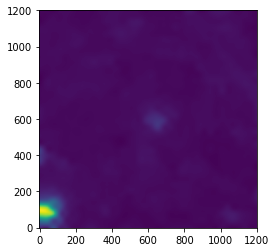

In [30]:
# Show the background 

plt.imshow(bkg_model.back(), interpolation='none', origin='lower')

# As you can see, the bright spots correspond to the central bright galaxy+star and the bottom-left 
# saturated star 

In [31]:
# Subtract the background from the image
imgsub_data = img_data - bkg_model.back()

# Object detection

# Detect 471 objects


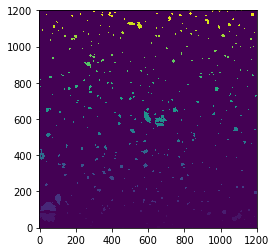

In [32]:
obj_table, seg_data = sep.extract(imgsub_data, 5.0, err=sig_data, mask=msk_data, 
                                  minarea=5, deblend_nthresh=32, deblend_cont=0.001,
                                  clean=True, segmentation_map=True)

"""
About the parameters used here, please read: 
https://sep.readthedocs.io/en/v1.0.x/api/sep.extract.html#sep.extract

And, feel free to play around these parameters. 
It will help you understand their effects. 
"""

print("# Detect %d objects" % len(obj_table))

# Visualize the segementation image
"""
Segementaion map: a map where the pixel value indicate which object it belongs to. 

e.g. A pixel whose value is 1, belong to the first object in the table.
"""
plt.imshow(seg_data, interpolation='none', origin='lower')

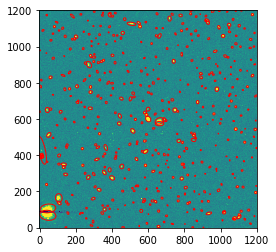

In [33]:
"""
Information extracted witin the obj_table can be found here: 

https://sep.readthedocs.io/en/v1.0.x/api/sep.extract.html#sep.extract

The really useful ones are: 

x, y:        object center using pixel coordinate 

x2, y2, xy : These also describe the shape of the ellipse, but using slightly different way.  
             These are called "2nd moments"; these are useful for Tractor.
             
a, b, theta: half major axis length, half minor axis length, the position angle of the ellipse that 
             describes the object; basically the size and shape of the object
             * theta is in unit of radian, need to (* 180.0 / np.pi) to convert it into unit of degree.
             
flux:        flux of object 

These are pretty much all we need for Tractor run.
"""

# Visualize the detected objects 
# You can use figure like this to see whether you detect all objects. 

fig, ax = plt.subplots()
img_avg, img_std = np.mean(imgsub_data), np.std(imgsub_data)

im = ax.imshow(imgsub_data, interpolation='nearest',
               vmin=(img_avg - img_std), vmax=(img_avg + img_std), 
               origin='lower')

for i in range(len(obj_table)):
    e = Ellipse(xy=(obj_table['x'][i], 
                    obj_table['y'][i]),
                width=(6 * obj_table['a'][i]),
                height=(6 * obj_table['b'][i]),
                angle=(obj_table['theta'][i] * 180. / np.pi))
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)


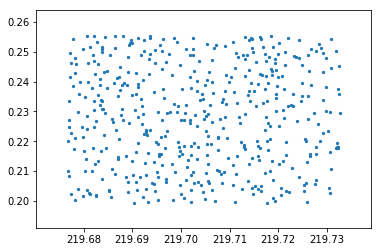

In [37]:
"""
You can convert the coordinates from (X, Y) into (RA, Dec) using the WCS information 

For example: 
"""

ra_obj, dec_obj = img_wcs.all_pix2world(obj_table['x'], obj_table['y'], 0)

# e.g. Plot the (RA, Dec) distributions of the objects
plt.scatter(ra_obj, dec_obj, s=5)

In [42]:
"""
You can convert the a, b values from the pixel unit into arcsec unit using the WCS.
"""

pixel_scale = np.abs(img_wcs.pixel_scale_matrix[0][0] * 3600.0)

a_arcsec, b_arcsec = (pixel_scale * obj_table['a']), (pixel_scale * obj_table['b'])

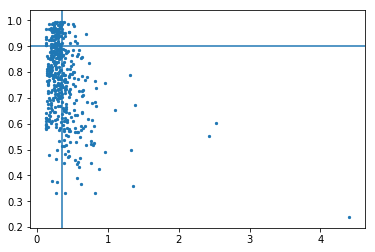

In [45]:
"""
We want to separate stars from galaxies, or small point-like sources from extended objects. 

In Tractor, they are modeled using different models: 
    1. Star/Point source: using Gaussian or PSF. 
    2. Galaxy/Extended object: using model like de Vaucouleurs or exponential (or Sersic) models.
    
This is difficult, now we are just using very naive assumption: small, round objects are stars.  

This confuse many faint, small galaxies as point sources; and really bright stars (e.g. saturated ones) 
will be separated into a few extended objects. 

The "roundness" of the object is described by "axis ratio" == b / a. 
    b / a = 1.0 : perfectly round object.
    b / a very small: very elongated object. 
    
And, if the half-length of the major axis of the ellipse is smaller than the size of the seeing, the 
object is small enough to be considered as point source. 
"""

# Plot the size v.s. shape 
plt.scatter(a_arcsec, (b_arcsec / a_arcsec), s=5)

"""
For example: 

We can define b/a > 0.9 as criteria to separate round object. 

And, if the Full-Width Half-Maximum (FWHM) of the seeing is 0.7 arcsec, half size is 0.35 arcsec
So, objects with a_arcsec < 0.35 are very much likely to be real point sources. 
"""

plt.axhline(0.9)
plt.axvline(0.35)

# Objects in the upper left corner are "stars"

# Todo list

* For the 10 galaxies:
    1. Take the central 400x400 pixels of the image, sigma, and mask 
    2. Perform background subtractin 
    3. Detect all objects above the 5-sigma threshold
    4. Visualize these detections using the ellipse of each object (see above)
    5. Plot the half-lenght of major axis in unit of arcsec (a_arcsec) and the axis ratio of the ellipse 
       (b_arcsec / a_arcsec); Select the a_arcsec < 0.35 and (b_arcsec / a_arcsec) > 0.9 objects as point
        sources. 
    6. Create a astropy.table for each object, save the 'x, y, x2, y2, xy, a, b, theta, flux' inforamtion.
    7. Add a boolean column to indicate which object is point source. 
    8. Save the table into a FITS catalog. 
    
* After this, we can feed the images and catalogs to Tractor. The format is similar to this: 
    - http://thetractor.org/doc/intro2.html#galaxies